In [1]:
%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(0,'/Users/quentinc/Documents/UCL/TauREx3-master/TauREx3')



In [2]:
import taurex

In [3]:
from taurex.model import TransmissionModel,EmissionModel,DirectImageModel,ForwardModel

taurex - INFO - Root logger initialized
taurex - ERROR - MIE could not be loaded


In [4]:
from taurex.data.spectrum import BaseSpectrum

class PhaseCurveSpectrum(BaseSpectrum):
    """A base class where spectrums are loaded (or later created). This
    is used to either plot against the forward model or passed into the optimizer to be used
    to fit the forward model

    Parameters
    ----------
    
    name : str 
        Name to be used in logging

    
    """


    def __init__(self,phase_path):
        super().__init__('PhaseSpectrum')
        self.load_spectrum(phase_path)
    
    @property
    def phaseAngles(self):
        return [p for p,s in self.phases]
    
    def load_spectrum(self,phase_path):
        import glob
        import pathlib
        all_files = glob.glob(os.path.join(phase_path,'*.dat'))

        self.phases = []

        for f in all_files:
            import re
            phase_value = float(re.findall(r'\d+.\d+',pathlib.Path(f).stem)[-1])
            self.phases.append((phase_value,np.loadtxt(f)))
            
        self._wngrid = [10000/s[:,0] for p,s in self.phases]
        argsort = [wngrid.argsort() for wngrid in self._wngrid]
        
        self._wngrid = [10000/p[1][a,0] for p,a in zip(self.phases,argsort)]
        self._wlgrid = [p[1][a,0] for p,a in zip(self.phases,argsort)]
        self._spectrum = np.concatenate([p[1][a,1] for p,a in zip(self.phases,argsort)])
        
        self._error = np.concatenate([p[1][a,2] for p,a in zip(self.phases,argsort)])
        
        
    @property
    def spectrum(self):
        """
        **Requires Implementation**


        Should return the observed spectrum.

        Raises
        ------
        NotImplementedError

        """
        return self._spectrum

    @property
    def rawData(self):
        """
        **Requires Implementation**


        Should return the raw data set.

        Raises
        ------
        NotImplementedError

        """
        raise NotImplementedError

    @property
    def wavelengthGrid(self):
        """
        **Requires Implementation**


        Should return the wavelength grid of the spectrum in microns. This does not
        need to necessarily match the shape of :func:`spectrum`

        Raises
        ------
        NotImplementedError

        """
        return self._wlgrid
    
    @property
    def wavenumberGrid(self):
        """
        Wavenumber grid in cm-1

        Returns
        -------
        wngrid : :obj:`array`

        """
        return self._wngrid
    
    @property
    def binEdges(self):
        """
        **Requires Implementation**


        Should return the bin edges of the wavelength grid

        Raises
        ------
        NotImplementedError

        """
        raise NotImplementedError
    
    @property
    def binWidths(self):
        """
        **Requires Implementation**


        Should return the widths of each bin in the wavelength grid

        Raises
        ------
        NotImplementedError

        """
        raise NotImplementedError


    @property
    def errorBar(self):
        """
        **Requires Implementation**


        Should return the error. *Must* be the same shape as
        :func:`spectrum`

        Raises
        ------
        NotImplementedError

        """
        return self._error
    
    def write(self,output):
        output.write_array('wlgrid',self.wavelengthGrid)
        output.write_array('spectrum',self.spectrum)
        output.write_array('binedges',self.binEdges)
        output.write_array('binwidths',self.binWidths)
        output.write_array('errorbars', self.errorBar)

        return output


In [5]:
obs = PhaseCurveSpectrum("C:/Users/Ahmed/Documents/repos/Phasecurves")

ValueError: need at least one array to concatenate

In [ ]:
obs.phaseAngles

In [5]:
from taurex.data.profiles.temperature import Guillot2010
from taurex.data.profiles.chemistry import TaurexChemistry,ConstantGas
from taurex.cache import OpacityCache

OpacityCache().set_opacity_path("/Users/quentinc/Documents/UCL/TauGit/Input/xsec/TauRex_sampled_xsecs_R10000_0.3-15")

In [ ]:
from taurex.log import Logger
import numexpr as ne
class PhaseCurveModel(Logger):
    
        
    
    def __init__(self,phase=0.0,term_size=0.1,nslice=3,ngauss=8):
        super().__init__('PhaseCurve')
        
        self._phase = phase
        
        self._ngauss = ngauss
        self._term_size = term_size
        self.couple_models()
    @property
    def terminatorSize(self):
        return self._term_size
    
    @terminatorSize.setter
    def terminatorSize(self,value):
        self._term_size = value
        self.couple_models()
    
    @property
    def phase(self):
        return self._phase
        
    @phase.setter
    def phase(self,value):
        self._phase = value
        self.couple_models()
    @property
    def angle(self):
        return self.phase
    
    
    def couple_models(self):
        
        mu,weight =np.polynomial.legendre.leggauss(self._ngauss*2)
        mu_quads =mu[self._ngauss:] 
        wi_quads =weight[self._ngauss:] 
        
        coefficients = np.zeros((3,self._ngauss))
        
        for idx,mu in enumerate(mu_quads):
            vals =  list(self.coeff_calc(mu))
            coefficients[:,idx] = vals[:]
            
            
        self._coefficients = coefficients
            
    
                

                
    def calc_angle(self,P, m, K):
       # pi = 3.14159265359
        #P = P * pi / 180
        return m*m*np.cos(P)/((1-np.cos(P)*np.cos(P))*np.sqrt(1-m*m))*(1+K*K+2*K*np.sqrt(1+0.25*(np.cos(P)*np.cos(P)-1)*(np.cos(P)*np.cos(P)-1)/(np.cos(P)*np.cos(P))))
    
    
    
    

    def coeff_calc(self, mu):
        pi = np.pi
        inv = False   
        angle = self.angle
        if angle > 90 or angle < 0:
            angle = 90 - angle % 90
            inv = True
        
        inv = not inv
        angle = angle * pi / 180
        term_size = self.terminatorSize * pi / 180



        arcCp = np.arccos(self.calc_angle(angle, mu, term_size))
        arcCm = np.arccos(self.calc_angle(angle, mu, -term_size))
        
        arcCp = 2*np.sqrt(1-mu**2)*arcCp
        arcCm = 2*np.sqrt(1-mu**2)*arcCm


        if np.isnan(arcCp) and np.isnan(arcCm):
            Ld = pi
            Lt = 0
            Ln = 0
        elif np.isnan(arcCp):
            Ld = pi - arcCm
            Lt = arcCm
            Ln = 0
        else:
            Ld = pi - arcCm
            Lt = arcCm - arcCp
            Ln = arcCp

        if inv == True:
            Coeff_temp = Ld
            Ld = Ln
            Ln = Coeff_temp


        Ld = Ld / pi
        Lt = Lt / pi
        Ln = Ln / pi

        return Ld, Lt, Ln
    
    def compute_emission_flux(self,day_emission,terminator_emission,night_emission,flux_function):
        
        day_I,day_mu,day_w,day_tau = day_emission
        term_I,term_mu,term_w,term_tau = terminator_emission
        night_I,night_mu,night_w,night_tau = night_emission
        
        
        day_coeffs = self._coefficients[0,:]
        day_coeffs = day_coeffs[:,None]
        term_coeffs = self._coefficients[1,:]
        term_coeffs = term_coeffs[:,None]
        night_coeffs = self._coefficients[2,:]
        night_coeffs = night_coeffs[:,None]
        
        day_flux_total = 2.0*np.pi*ne.evaluate('sum(day_I*day_mu*day_w*day_coeffs,axis=0)')
        term_flux_total = 2.0*np.pi*ne.evaluate('sum(term_I*term_mu*term_w*term_coeffs,axis=0)')
        night_flux_total = 2.0*np.pi*ne.evaluate('sum(night_I*night_mu*night_w*night_coeffs,axis=0)')

        
        final_flux = flux_function(day_flux_total) + flux_function(term_flux_total) + flux_function(night_flux_total)
    
        
        return final_flux
        
        
        

In [ ]:
from taurex.data.profiles.pressure import SimplePressureProfile
from taurex.data.fittable import fitparam
class MultiPhaseModel(ForwardModel):
    
    
    
    def __init__(self,phases=None,
                 terminator_size = 10.0,tp=[None]*3,chemistry=[None]*3,pressure_min=[1e-6]*3,pressure_max = [1e6]*3,nlayers=[100]*3,
                 planet=None,star = None,contributions=None,ngauss=8,use_directimage=False):
        super().__init__('MultiPhaseModel')
        self._phases = phases
        self._term_size = terminator_size
        self._use_directimage = use_directimage
        self.create_models(tp,chemistry,pressure_min,pressure_max,nlayers,planet,star,contributions,ngauss)
        
        self.create_phases(ngauss=ngauss)
        self.terminatorSize = terminator_size

        class PhaseChemistry(object):
            
            def __init__(self,day,term,night):
                self._chem = [day,term,night]

            
            @property
            def activeGasMixProfile(self):
                return np.stack([c.activeGasMixProfile for c in self._chem])
            @property
            def inactiveGasMixProfile(self):
                return np.stack([c.inactiveGasMixProfile for c in self._chem])
        
        self.chemistry = PhaseChemistry(self.day_chem,self.term_chem,self.night_chem)
    @fitparam(param_name="terminator_size",param_latex="Term_size",default_fit=False,default_mode='linear',default_bounds=[0.1,0.5])
    def terminatorSize(self):
        return self._term_size
    
    @terminatorSize.setter
    def terminatorSize(self,value):
        self._term_size = value
        phase_models = [pc for pc in self._phase_model if isinstance(pc,PhaseCurveModel) ]
        
        
        
        for pc in phase_models:
            pc.terminatorSize = self._term_size
        

    def change_fit_values(self,v,prefix):
        name,latex,fget,fset,mode,to_fit,bounds = v
        name = '{}_{}'.format(prefix,name)
        latex = '{}_{}'.format(prefix,latex)
        return name,latex,fget,fset,mode,to_fit,bounds
        
    
    def create_models(self,tp,chemistry,pressure_min,pressure_max,nlayers,planet,star,contributions,ngauss):
        
        
        #Day models
        planet = planet
        star = star
        day_tp = tp[0]
        day_chem = chemistry[0]
        day_pressure_min = pressure_min[0]
        day_pressure_max = pressure_max[0]
        day_nlayers = nlayers[0]
        day_contribs = contributions[0]

        emissionModel = EmissionModel
        
        if self._use_directimage:
            emissionModel = DirectImageModel
        
        
        
        day_pressure_prof = SimplePressureProfile(atm_min_pressure=day_pressure_min,atm_max_pressure=day_pressure_max,nlayers=day_nlayers)
        
        
        day_emission = emissionModel(temperature_profile=day_tp,chemistry=day_chem,planet=planet,star=star,
                                            pressure_profile=day_pressure_prof,ngauss=ngauss)
        
        for c in day_contribs:
            day_emission.add_contribution(c)
        
        
        #Terminator models
        term_tp = tp[1]
        term_chem = chemistry[1]
        term_pressure_min = pressure_min[1]
        term_pressure_max = pressure_max[1]
        term_nlayers = nlayers[1]
        term_contribs = contributions[1]
 
        term_pressure_prof = SimplePressureProfile(atm_min_pressure=term_pressure_min,atm_max_pressure=term_pressure_max,nlayers=term_nlayers)
        
        

        phase_terminator_emission = emissionModel(temperature_profile=term_tp,chemistry=term_chem,planet=planet,star=star,
                                            pressure_profile=term_pressure_prof,ngauss=ngauss)
        
 

        transmission = TransmissionModel(temperature_profile=term_tp,chemistry=term_chem,planet=planet,star=star,
                                            pressure_profile=term_pressure_prof)
       
        for c in term_contribs:
            phase_terminator_emission.add_contribution(c)  
            transmission.add_contribution(c)
        
        
        night_tp = tp[2]
        night_chem = chemistry[2]
        night_pressure_min = pressure_min[2]
        night_pressure_max = pressure_max[2]
        night_nlayers = nlayers[2]
        night_contribs = contributions[2]

        night_pressure_prof = SimplePressureProfile(atm_min_pressure=night_pressure_min,atm_max_pressure=night_pressure_max,nlayers=night_nlayers)
        
        phase_night_emission = emissionModel(temperature_profile=night_tp,chemistry=night_chem,planet=planet,star=star,
                                            pressure_profile=night_pressure_prof,ngauss=ngauss)

        
        for c in night_contribs:
            phase_night_emission.add_contribution(c)  
        
        
        self._phase_day = day_emission
        self._phase_term = phase_terminator_emission
        self._transmission = transmission
        self._phase_night = phase_night_emission
        
        
        self.planet = planet 
        self.star =star
        
        
        self.day_tp =day_tp 
        self.day_chem = day_chem
        self.day_pressure = day_pressure_prof
        self.day_contribs = day_contribs

        self.term_tp =term_tp 
        self.term_chem = term_chem
        self.term_pressure = term_pressure_prof
        self.term_contribs = term_contribs

        self.night_tp =night_tp 
        self.night_chem = night_chem
        self.night_pressure = night_pressure_prof
        self.night_contribs = night_contribs

    @property
    def nLayers(self):
        return self.pressure.nLayers
        
    @property
    def densityProfile(self):
        from taurex.constants import KBOLTZ
        #np.stack([self._phase_day,self._phase_term,self._phase_night])
        return np.stack([self._phase_day.densityProfile,self._phase_term.densityProfile,self._phase_night.densityProfile])

    @property
    def altitudeProfile(self):
        from taurex.constants import KBOLTZ
        #np.stack([self._phase_day,self._phase_term,self._phase_night])
        return np.stack([self._phase_day.altitudeProfile,self._phase_term.altitudeProfile,self._phase_night.altitudeProfile])
    
    @property
    def temperatureProfile(self):
        
        return np.stack([self.day_tp.profile,self.term_tp.profile,self.night_tp.profile])

    @property
    def pressureProfile(self):
        
        return np.stack([self.day_pressure.profile,self.term_pressure.profile,self.night_pressure.profile])
    
    @property
    def scaleheight_profile(self):
        return np.stack([self._phase_day.scaleheight_profile,self._phase_term.scaleheight_profile,
                             self._phase_night.scaleheight_profile])
    
    @property
    def gravity_profile(self):
        return np.stack([self._phase_day.gravity_profile,self._phase_term.gravity_profile,
                     self._phase_night.gravity_profile])       
    
    def create_phases(self,ngauss=8):
        
        self._phase_model = []
        
        for phase in self._phases:
            
            if phase == 0:
                self._phase_model.append(self.compute_transit)
            elif phase == 180:
                self._phase_model.append(self.compute_eclipse)
            else:
                pc = PhaseCurveModel(phase=phase,term_size=self.terminatorSize,ngauss=ngauss)
                self._phase_model.append(pc.compute_emission_flux)

    def collect_base_fitting_params(self):
        self._fitting_parameters = {}
        self._fitting_parameters.update(self.fitting_parameters()) 
        self._fitting_parameters.update(self.planet.fitting_parameters())
        self._fitting_parameters.update(self.star.fitting_parameters())
        
        for k,v in self.day_tp.fitting_parameters().items():
            
            self._fitting_parameters['day_{}'.format(k)] =self.change_fit_values(v,'day')
            
        for k,v in self.day_chem .fitting_parameters().items():

            self._fitting_parameters['day_{}'.format(k)] =self.change_fit_values(v,'day')
        for k,v in self.day_pressure.fitting_parameters().items():
            self._fitting_parameters['day_{}'.format(k)] =self.change_fit_values(v,'day')
            
        for c in self.day_contribs:
            for k,v in c.fitting_parameters().items():
                self._fitting_parameters['day_{}'.format(k)] =self.change_fit_values(v,'day')

        for k,v in self.term_tp.fitting_parameters().items():
            self._fitting_parameters['term_{}'.format(k)] =self.change_fit_values(v,'term')
        for k,v in self.term_chem .fitting_parameters().items():
            self._fitting_parameters['term_{}'.format(k)] =self.change_fit_values(v,'term')
        for k,v in self.term_pressure.fitting_parameters().items():
            self._fitting_parameters['term_{}'.format(k)] =self.change_fit_values(v,'term')
            
        for c in self.term_contribs:
            for k,v in c.fitting_parameters().items():
                self._fitting_parameters['term_{}'.format(k)] =self.change_fit_values(v,'term')
            
        for k,v in self.night_tp.fitting_parameters().items():
            self._fitting_parameters['night_{}'.format(k)] =self.change_fit_values(v,'night')
        for k,v in self.night_chem .fitting_parameters().items():
            self._fitting_parameters['night_{}'.format(k)] =self.change_fit_values(v,'night')
        for k,v in self.night_pressure.fitting_parameters().items():
            self._fitting_parameters['night_{}'.format(k)] =self.change_fit_values(v,'night')
            
        for c in self.night_contribs:
            for k,v in c.fitting_parameters().items():
                self._fitting_parameters['night_{}'.format(k)] =self.change_fit_values(v,'night')
    def build(self):
        self._phase_day.build()
        self._phase_term.build()
        self._transmission.build()
        self._phase_night.build()

        self.collect_base_fitting_params()

        
    def compute_eclipse(self,day_emission,terminator_emission,night_emission,flux_function):
        
        day_I,day_mu,day_w,day_tau = day_emission

        
        day_flux_total = 2.0*np.pi*ne.evaluate('sum(day_I*day_mu*day_w,axis=0)')

        
        final_flux = flux_function(day_flux_total)
        
        return final_flux

    def compute_transit(self,*args):
        return self._transmission.model(wngrid=None)[0]
    @property
    def nativeWavenumberGrid(self):
        return self._transmission.nativeWavenumberGrid
    
    
    def model(self,wngrid=None,return_contrib=False,cutoff_grid=True):
        from taurex.util import bindown
        
        transmission = None
        day_emission = None
        term_emission = None
        night_emission = None
        
        native_grid = self.nativeWavenumberGrid
        if wngrid is not None:
            if isinstance(wngrid,np.ndarray):
                wngrid = [wngrid]*len(self._phases)
                
        else:
            wngrid = [None]*len(self._phases)
            
        
        if not isinstance(wngrid,(list,)):
            raise Exception('Must supply a list of binning grid or None if not binning')
            
            
            
        res = []
        

            
        if any(p > 0.0 and p <= 180.0 for p in self._phases):
            day_emission = self._phase_day.partial_model(wngrid=None,return_contrib=return_contrib,cutoff_grid=cutoff_grid)
            term_emission = self._phase_term.partial_model(wngrid=None,return_contrib=return_contrib,cutoff_grid=cutoff_grid)
            night_emission = self._phase_night.partial_model(wngrid=None,return_contrib=return_contrib,cutoff_grid=cutoff_grid)
        
        
        for phase_wngrid,model in zip(wngrid,self._phase_model):
            
            native_result = model(day_emission,term_emission,night_emission,self._phase_day.compute_final_flux)
            
            if phase_wngrid is None:
                res.append((native_result,native_result,None,{}))
            else:
                
                new_absp = bindown(native_grid,native_result,phase_wngrid)
                res.append((new_absp,native_result,None,{}))
                
        binned_phase = np.concatenate([r[0] for r in res])
        native_phase = np.vstack([r[1] for r in res])
        tau_phase = [r[2] for r in res]
        
        return binned_phase,native_phase,tau_phase,{}
        
        

In [152]:
from taurex.data.profiles.temperature import Guillot2010,Isothermal
from taurex.data import Planet
from taurex.data.stellar import BlackbodyStar
from taurex.contributions import *
import random
import logging
from taurex.model import MultiPhaseModel


planet = Planet()
tp = [Guillot2010(T_irr=1600.0),Guillot2010(T_irr=1000.0),Guillot2010(T_irr=500.0)]
#tp = [Isothermal(iso_temp=1600.0),Isothermal(iso_temp=1000.0),Isothermal(iso_temp=500.0)]
#tp = [Guillot2010(T_irr=1500.0+random.randrange(-500,500)) for x in range(3)]
chem = [TaurexChemistry() for x in range(3)]
for c in chem:
    c.addGas(ConstantGas('H2O',mix_ratio=1e-3))
    c.addGas(ConstantGas('CH4',mix_ratio=1e-4))
star = BlackbodyStar()

contribs=[[AbsorptionContribution()],[AbsorptionContribution()],[AbsorptionContribution()]]


multiphase = MultiPhaseModel(phases=[45],
                 terminator_size=10.0, temperature_profile=tp, chemistry=chem, pressure_min=[1e-6] * 3,
                 pressure_max=[1e6] * 3, nlayers=[100] * 3, pressure_profile = [None]*3,
                 planet=planet, star=star, contributions=contribs, ngauss=8, use_directimage=False)

multiphase.build()

0.09501250983763745 81.36062928754386 100.63976129483727
Coeffs D-T-N:  0.5565804162247279 -0.10662174849197797 0.5500413322672502 	 sum:  1.0
0.2816035507792589 87.00383169438507 107.16490246738458
Coeffs D-T-N:  0.5712668293857505 -0.1074731625031659 0.5362063331174154 	 sum:  1.0
0.45801677765722737 98.69404613647659 121.7446852425259
Coeffs D-T-N:  0.6012452913311854 -0.11383731615945404 0.5125920248282686 	 sum:  1.0
0.6178762444026438 118.70133642238964 154.71355739552348
Coeffs D-T-N:  0.6758192139787064 -0.15730845622967346 0.4814892422509671 	 sum:  1.0
0.755404408355003 169.69985967455014 nan
Coeffs D-T-N:  0.0 0.61776298555081 0.38223701444919006 	 sum:  1.0
0.8656312023878318 nan nan
Coeffs D-T-N:  0.0 0.0 1.0 	 sum:  1.0
0.9445750230732326 nan nan
Coeffs D-T-N:  0.0 0.0 1.0 	 sum:  1.0
0.9894009349916499 nan nan
Coeffs D-T-N:  0.0 0.0 1.0 	 sum:  1.0


In [10]:
wngrid_list=None


#multi_res = multiphase.model(wngrid=obs.wavenumberGrid)
multi_res = multiphase.model()

taurex.PickleOpacity:H2O.R10000 - INFO - Loading opacity from /Users/quentinc/Documents/UCL/TauGit/Input/xsec/TauRex_sampled_xsecs_R10000_0.3-15/H2O.R10000.TauREx.pickle
taurex.OpacityCache - INFO - Reading opacity H2O
taurex.OpacityCache - INFO - Loading opacity H2O into model
taurex.PickleOpacity:CH4.R10000 - INFO - Loading opacity from /Users/quentinc/Documents/UCL/TauGit/Input/xsec/TauRex_sampled_xsecs_R10000_0.3-15/CH4.R10000.TauREx.pickle
taurex.OpacityCache - INFO - Reading opacity CH4
taurex.OpacityCache - INFO - Loading opacity CH4 into model
taurex.EmissionModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.Absorption - INFO - Recomputing active gas H2O opacity
taurex.Absorption - INFO - Recomputing active gas CH4 opacity
taurex.Absorption - INFO - Done
taurex.EmissionModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.Absorption - INFO - Recomputing active gas H2

In [ ]:
multi_res[2]

In [11]:
wlgrid = 10000/multiphase.nativeWavenumberGrid

In [ ]:
import os
[0.0,1.0,45.0,90.0,135.0,180.0]

for phase,model in zip(multiphase._phases,multi_res[1]):
    name = 'phase_{}.txt'.format(phase)
    directory = 'C:/Users/Ahmed/Documents/repos/Phasecurves'
    if phase == 0:
        name = 'transmission.txt'
    if phase == 180.0:
        name = 'emission.txt'
    print(model.shape)
    print(wlgrid.shape)
    
    filename = os.path.join(directory,name)
    
    with open(filename,'w') as f:
        np.savetxt(f,np.stack((wlgrid,model)).T)
    

In [ ]:
plt.figure()
plt.plot(multi_res[0])
plt.show()

In [7]:

%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import taurex
sys.path.insert(0,'/Users/quentinc/Documents/UCL/TauREx3-master/TauREx3')
from taurex.log import disableLogging
disableLogging()

from taurex.model import TransmissionModel,EmissionModel,DirectImageModel,ForwardModel

from taurex.data.profiles.temperature import Guillot2010
from taurex.data.profiles.chemistry import TaurexChemistry,ConstantGas
from taurex.cache import OpacityCache

OpacityCache().set_opacity_path("/Users/quentinc/Documents/UCL/TauGit/Input/xsec/TauRex_sampled_xsecs_R10000_0.3-15")

from taurex.data.profiles.temperature import Guillot2010,Isothermal
from taurex.data import Planet
from taurex.data.stellar import BlackbodyStar
from taurex.contributions import *
import random
import logging
from taurex.model import MultiPhaseModel


planet = Planet()
tp = [Guillot2010(T_irr=1200.0),Guillot2010(T_irr=1400.0),Guillot2010(T_irr=1600.0)]
#tp = [Isothermal(iso_temp=1600.0),Isothermal(iso_temp=1000.0),Isothermal(iso_temp=500.0)]
#tp = [Guillot2010(T_irr=1500.0+random.randrange(-500,500)) for x in range(3)]
chem = [TaurexChemistry() for x in range(3)]
for c in chem:
    c.addGas(ConstantGas('H2O',mix_ratio=1e-3))
    c.addGas(ConstantGas('CH4',mix_ratio=1e-4))
star = BlackbodyStar()

contribs=[[AbsorptionContribution()],[AbsorptionContribution()],[AbsorptionContribution()]]


multiphase = MultiPhaseModel(phases=[45],
                 terminator_size=10.0, temperature_profile=tp, chemistry=chem, pressure_min=[1e-6] * 3,
                 pressure_max=[1e6] * 3, nlayers=[100] * 3, pressure_profile = [None]*3,
                 planet=planet, star=star, contributions=contribs, ngauss=8, use_directimage=False)

multiphase.build()
wlgrid = 10000/multiphase.nativeWavenumberGrid



In [8]:
def get_phase(phase=0.0,terminatorsize=10.0,gauss=8,wngrid=None):
    mpm = MultiPhaseModel(phases=[phase],terminator_size=terminatorsize,temperature_profile=tp,nlayers=[20]*3,
                                 chemistry=chem,planet=planet,star=star,contributions=contribs,ngauss=gauss)

    mpm.build()
    print()
    print(mpm._phase_model[0])
    return mpm.model()[1]

<IPython.core.display.Javascript object>


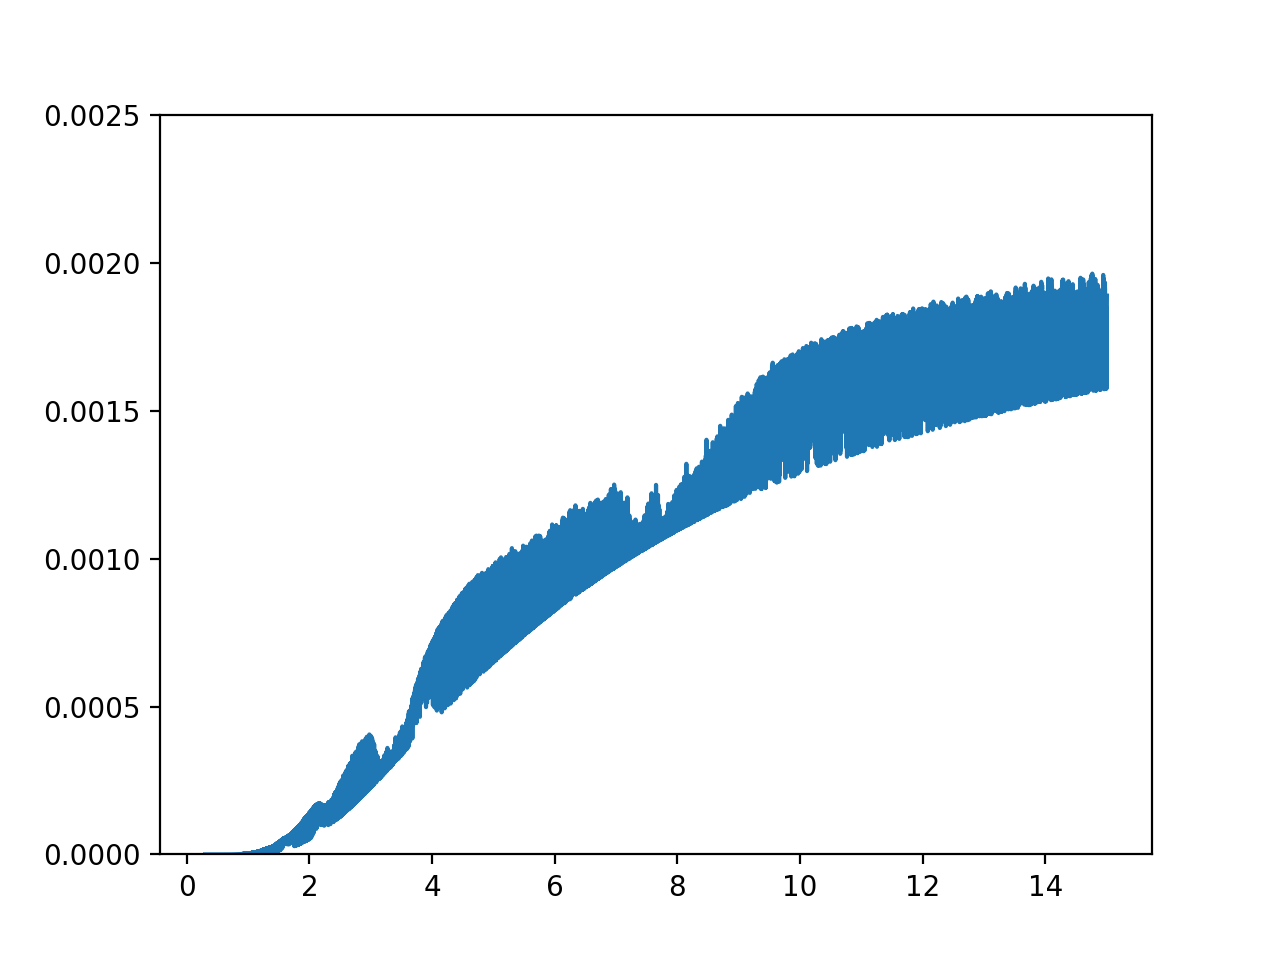


<bound method PhaseCurveModel.compute_emission_flux of <taurex.model.phasemodel.PhaseCurveModel object at 0x135b52e80>>


interactive(children=(FloatSlider(value=90.0, description='phase', max=180.0, step=5.0), FloatSlider(value=10.…

In [9]:
from ipywidgets import *

wngrid = multiphase.nativeWavenumberGrid


phase_fig = plt.figure()

phase_ax = phase_fig.add_subplot(1,1,1)

phase_model =  phase_ax.plot(wlgrid,get_phase(90.0,10.0,8,wngrid)[0])[0]

def update_phase(phase=90.0,terminator_size=10.0,ngauss=8):
    new_res = get_phase(phase,terminator_size,ngauss,wngrid)[0]
    print(phase)
    print(new_res)
    
    phase_model.set_ydata(new_res)
    
    phase_ax.axis(ymin=0,ymax=0.0025)
    #phase_ax.relim()
    #phase_ax.autoscale_view()
    phase_fig.canvas.draw()
    

interact(update_phase,phase=(0.0,180,5.0),terminator_size=(0.0,50,5),ngauss=(1,100,5));


In [ ]:
%prun multiphase.model(wngrid=obs.wavenumberGrid)

In [ ]:
from taurex.optimizer.nestle import NestleOptimizer

In [ ]:
no = NestleOptimizer(num_live_points=20)

In [ ]:
no.set_observed(obs)
no.set_model(multiphase)
no.disable_fit('day_T_irr')
no.disable_fit('term_T_irr')
no.disable_fit('night_T_irr')

In [ ]:
solution = no.fit()

In [ ]:
solution

In [ ]:
solution['solution0']['Spectra'].keys()

In [ ]:
solution['solution0']['Spectra']['Bins']['Bin0']

plt.figure()
plt.plot()

In [11]:
def returncos(P, K, mu,):
    return -np.cos(P)/(np.sqrt(1-mu**2)*(np.cos(P)**2-1))*(mu**2+K**2+2*K*np.sqrt(1+((np.cos(P)**2-1)/(2*np.cos(P)))**2))


-0.057466206617311846 0.7118269699140489


/anaconda3/envs/taurex3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/anaconda3/envs/taurex3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/anaconda3/envs/taurex3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/anaconda3/envs/taurex3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/anaconda3/envs/taurex3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/envs/taurex3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/envs/taurex3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/env

<IPython.core.display.Javascript object>


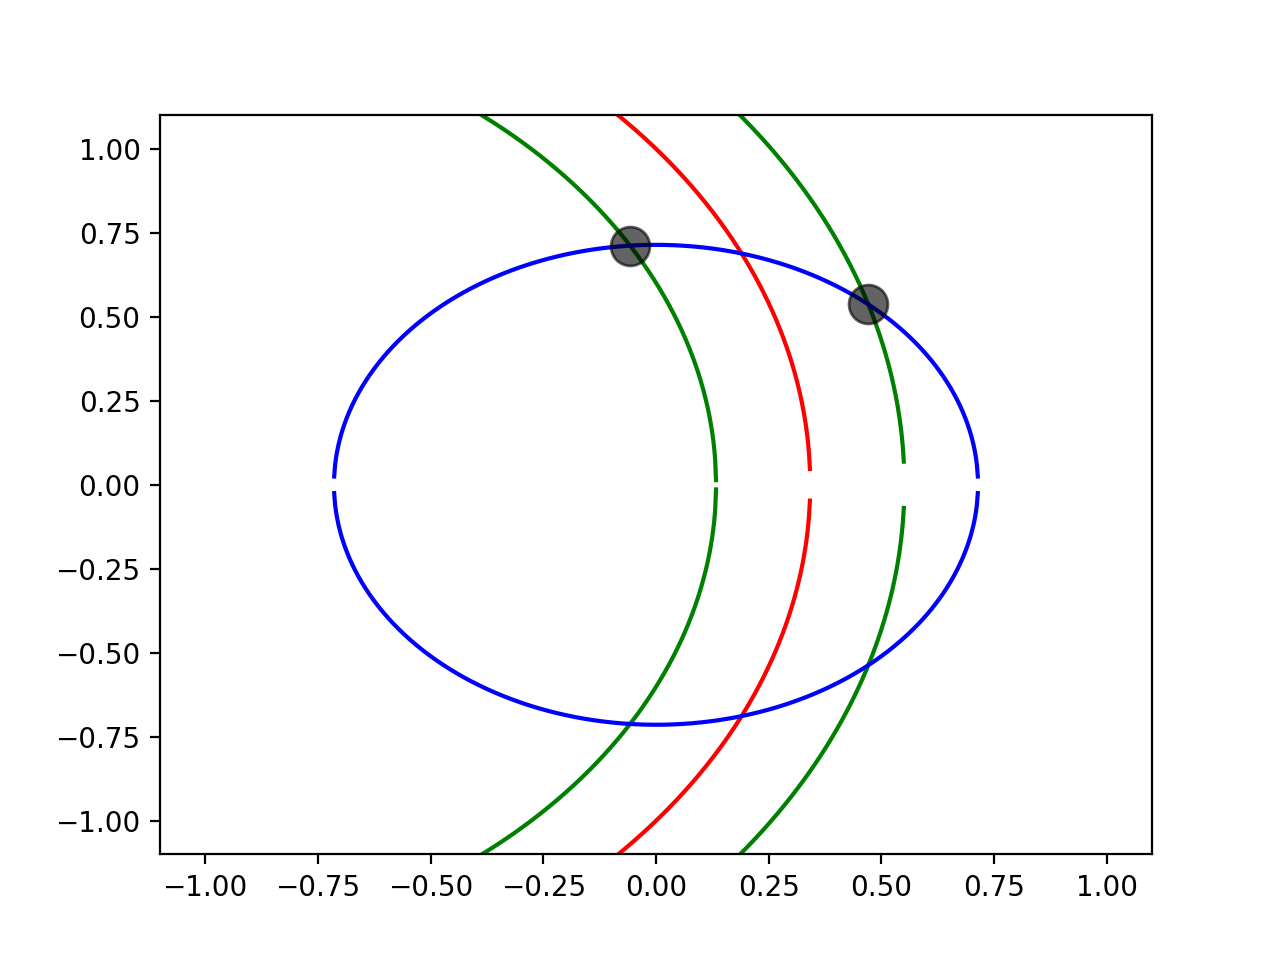

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import sys

mu = 0.7
P = 70
K = 40
P = P*np.pi/180
K = K/180 * np.sin(P)


x = np.linspace(-1,1,1000)
ru = [np.sqrt(1-mu**2-x[i]**2) for i in range(len(x))]
rl = [- np.sqrt(1-mu**2-x[i]**2) for i in range(len(x))]
yu = [np.sqrt(1-x[i]**2+x[i]*(np.cos(P)**2-1)/np.cos(P)) for i in range(len(x))]
yl = [- np.sqrt(1-x[i]**2+x[i]*(np.cos(P)**2-1)/np.cos(P)) for i in range(len(x))]
yKpu = [np.sqrt(1-x[i]**2+x[i]*(np.cos(P)**2-1)/np.cos(P)+2*K*np.sqrt(1+((np.cos(P)**2-1)/(2*np.cos(P)))**2)+K**2) for i in range(len(x))]
yKmu = [np.sqrt(1-x[i]**2+x[i]*(np.cos(P)**2-1)/np.cos(P)-2*K*np.sqrt(1+((np.cos(P)**2-1)/(2*np.cos(P)))**2)+K**2) for i in range(len(x))]
yKpl = [- np.sqrt(1-x[i]**2+x[i]*(np.cos(P)**2-1)/np.cos(P)+2*K*np.sqrt(1+((np.cos(P)**2-1)/(2*np.cos(P)))**2)+K**2) for i in range(len(x))]
yKml = [- np.sqrt(1-x[i]**2+x[i]*(np.cos(P)**2-1)/np.cos(P)-2*K*np.sqrt(1+((np.cos(P)**2-1)/(2*np.cos(P)))**2)+K**2) for i in range(len(x))]

cosA = returncos(P,K,mu)


X1 = np.sqrt(1-mu**2)*cosA
Y1 = np.sqrt(1-mu**2)*np.sqrt(1-cosA**2)

X2 = np.sqrt(1-mu**2)*returncos(P,-K,mu)
Y2 = np.sqrt(1-mu**2)*np.sqrt(1-returncos(P,-K,mu)**2)

print(X2,Y2)

plt.figure()
plt.plot(x,yu, color='red')
plt.plot(x,yl, color='red')
plt.plot(x,yKpu, color = 'green')
plt.plot(x,yKpl, color = 'green')
plt.plot(x,yKmu, color = 'green')
plt.plot(x,yKml, color = 'green')
plt.plot(x,ru, color='blue')
plt.plot(x,rl, color='blue')
plt.plot(X1,Y1, 'o',color= 'black',markersize=14, alpha=100)
plt.plot(X2,Y2, 'o',color= 'black',markersize=14, alpha=100)
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.show()